In [1]:
import openai
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from dotenv import load_dotenv
from os import getenv

load_dotenv()

True

In [2]:
data = pd.read_csv(getenv('OPIN_HU_BANK_PATH'), encoding='ISO-8859-2')
data.head(), data.columns

(   ID  START  LEN           Entity  \
 0   1     28    2      Schmitt Pál   
 1   2      7    2  Matolcsy György   
 2   3     15    2  Szijjártó Péter   
 3   4     18    2     Szabó Attila   
 4   5     12    2        P. Zoltán   
 
                                             Sentence  \
 0  A magyarok tiszta, egyértelmű, vállalható, jól...   
 1  A szóvivő megerősítette: a kabinet Matolcsy Gy...   
 2  A nyugdíjasok utazási kedvezményének megvonása...   
 3  Itt találta el az a lövés, amellyel egy vadász...   
 4  Egy csempész ismerőse szintén ,,cigiben utazó"...   
 
                                                  URL  Annot1  Annot2  Annot3  \
 0  http://kecskemetitv.hu/hun/sa_kecskemet/i_belf...       0       0       0   
 1  http://mti.hu/article-proxy/2011/02/18/szijjar...       0       0       0   
 2  http://mti.hu/article-proxy/2011/02/18/szijjar...       0       0       0   
 3  http://kecskemetitv.hu/hun/sa_zuschlag_per_kec...       0       0       0   
 4  http://atv.

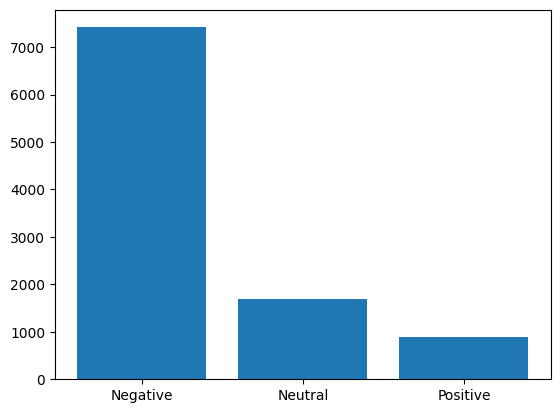

,Sentence,ConsensusSentiment
0,"A magyarok tiszta, egyértelmű, vállalható, jól...",0
1,A szóvivő megerősítette: a kabinet Matolcsy Gy...,0
2,A nyugdíjasok utazási kedvezményének megvonása...,0
3,"Itt találta el az a lövés, amellyel egy vadász...",0
4,"Egy csempész ismerőse szintén ,,cigiben utazó""...",-1


In [3]:
annotation_columns = ['Annot1', 'Annot2', 'Annot3', 'Annot4', 'Annot5']

data['ConsensusSentiment'] = mode(data[annotation_columns], axis=1).mode
sentiment_distribution = data['ConsensusSentiment'].value_counts()
modified_data_preview = data[['Sentence', 'ConsensusSentiment']].head()

plt.bar(['Negative', 'Neutral','Positive'],sentiment_distribution)
plt.show()

modified_data_preview

In [4]:
sample_data = data.groupby('ConsensusSentiment').apply(lambda x: x.sample(2, random_state=42)).reset_index(drop=True)
sample_sentences = sample_data['Sentence']
sample_sentiments = sample_data['ConsensusSentiment'].replace({-1: 'Negative', 0: 'Neutral', 1: 'Positive'})

sample_data[['Sentence','ConsensusSentiment']]

C:\Users\mrkoc\AppData\Local\Temp\ipykernel_8620\2125145812.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_data = data.groupby('ConsensusSentiment').apply(lambda x: x.sample(2, random_state=42)).reset_index(drop=True)


,Sentence,ConsensusSentiment
0,A frissen kinevezett biztos júniusban három vi...,-1
1,"Hét izraeli, köztük Gal és nagyanyja, Noah Alo...",-1
2,- Egy-egy szerető is feltűnik Szabó Zsófi és S...,0
3,"Szalay-Berzeviczy Attila úgy véli, a gazdasági...",0
4,",,Szögi Lajos családja közel száz milliót kapo...",1
5,Páva Zsolt kiemelte: Prinz Gyula ahhoz a klass...,1


In [5]:
few_shot_prompt= "You are a native Hungarian speaker. Amazing at recognizing even the most suble sings of a of particular sentiment in a sentence. Here's the task:\n\n"
few_shot_prompt += "\n\n".join([f"Text: {text}\nSentiment: {sent}" for text, sent in zip(sample_sentences, sample_sentiments)])
few_shot_prompt += "\n\n"

print(few_shot_prompt)

You are a native Hungarian speaker. Amazing at recognizing even the most suble sings of a of particular sentiment in a sentence. Here's the task:

Text: A frissen kinevezett biztos júniusban három vizsgálandó ügycsoportot nevezett meg: az egyikben az off-shore-cégekkel összefüggésben a Wallis-csoport, Oszkó Péter korábbi pénzügyminiszter, a Magyar Villamos Művek és a Magyar Nemzeti Bank szerepelt, a másodikban a ferihegyi repülőtér és a Malév privatizációja, a harmadikban pedig közérdekű adatokkal való visszaélésről volt szó Gyurcsány Ferenc és Veres János esetében a 2006-os választások előtt állítólag meghamisított államháztartási adatok miatt.
Sentiment: Negative

Text: Hét izraeli, köztük Gal és nagyanyja, Noah Alon vesztette életét a robbanásban, amelyben további mintegy ötven személy megsebesült.
Sentiment: Negative

Text: - Egy-egy szerető is feltűnik Szabó Zsófi és Szabó Máté személyében, akik mind ahhoz segítik a párosunkat, hogy újra egymásra találjuk.
Sentiment: Neutral

Text

In [6]:
client = openai.OpenAI()

def analyze_sentiment_with_openai(prompt, sentences, model="gpt-3.5-turbo-instruct", max_tokens=60):
    responses = []
    for sentence in sentences:
        full_prompt = prompt + f"Text: {sentence}\nSentiment:"
        response = client.completions.create(
            model=model,
            prompt=full_prompt,
            max_tokens=max_tokens,
            n=1,
            stop=None
        )
        responses.append((sentence, response.choices[0].text.strip()))
    return responses

In [7]:
test_data = data.sample(3, random_state=1)
test_sentences = test_data['Sentence'].tolist()
results = analyze_sentiment_with_openai(few_shot_prompt, test_sentences)

for result,real_sentiment in zip(results,test_data['ConsensusSentiment']):
    print(f"Sentence: {result[0]}")
    print(f"Predicted Sentiment: {result[1]}")
    print(f"Real Sentiment: {['Negative', 'Neutral','Positive'][real_sentiment+1]}")
    print()

Sentence: Rogán Antal azt mondta: alapos, mindenre kiterjedő beszámolót hallottak az atomerőmű vezérigazgatójától, ez és a látottak, tapasztaltak meggyőzték őket arról, hogy Magyarországon az atomtechnológia működtetése megnyugtató.
Predicted Sentiment: Positive
Real Sentiment: Neutral

Sentence: Czaun János (civilben rátóti lakos és egyben a terület önkormányzati képviselője hangoztatta, számos fórumot szervezett már) egyetért Nagy Piroskával abban, hogy át kell gondolni még a témát, amely ekkora indulatokat hozott ki az emberekből.
Predicted Sentiment: Neutral
Real Sentiment: Neutral

Sentence: Fülöp Gergely, a Szabolcs-Szatmár-Bereg Megyei Rendőr-főkapitányság szóvivője az MTI-nek elmondta: a Nyíregyháza felől érkező autó eddig tisztázatlan körülmények között - vélhetően előzés közben - az árokba, majd egy fának csapódott.
Predicted Sentiment: Negative
Real Sentiment: Neutral



['Positive', 'Neutral', 'Negative', 'Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Negative', 'Negative', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive

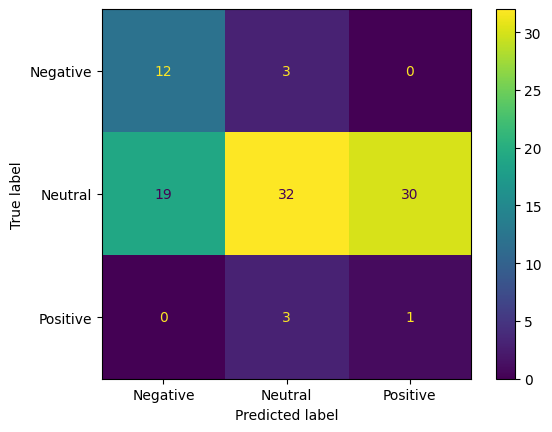

In [8]:
results = analyze_sentiment_with_openai(few_shot_prompt, data['Sentence'][:100].tolist())
true_sentiments = data['ConsensusSentiment'][:100].replace({-1: 'Negative', 0: 'Neutral', 1: 'Positive'})
pred_sentiments = [result[1] for result in results]
print(pred_sentiments)

conf_matrix = confusion_matrix(true_sentiments, pred_sentiments, labels=['Negative', 'Neutral','Positive'])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=['Negative', 'Neutral','Positive'])
disp.plot()
plt.show()